<a href="https://colab.research.google.com/github/JakeOh/202505_BD50/blob/main/lab_da/ml19_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN  연습

*   Keras 패키지의 손글씨 MNIST 예제 데이터셋을 다운로드하세요.
*   예제 데이터셋의 일부(예: 100개)를 시각화해 보세요.
*   훈련 셋과 테스트 셋의 데이터는 0. ~ 1. 스케일로 스케일링하세요.
*   전체 훈련 셋은 다시 훈련 셋과 검증 셋으로 나누세요.
*   아래의 CNN 모델 구조처럼 합성곱 신경망을 설계하세요.
*   모든 합성곱 층의 커널 사이즈는 3으로 설정하세요.
*   모든 합성곱 층(Conv2D)와 출력층을 제외한 밀집층(Dense)에서
    *   활성화 함수는 ReLU로 설정하세요.
    *   커널 초기화 함수(kernel initializer)를 'he_normal'로 설정하세요.
*   첫번째 Dropout 층의 rate는 0.25로 설정하세요.
*   두번째 Dropout 층의 rate는 0.5로 설정하세요.
*   모델의 옵티마이저(optimizer)는 Nadam을 사용하세요.
*   ModelCheckpoint, EarlyStopping 콜백들과 검증 셋을 함께 사용해서 모델을 훈련하세요.
    *   최적의 모델은 cnn_ex_best.keras 파일로 저장하세요.
*   모델의 성능을 평가하세요.

---

__CNN example__

<img src="https://raw.githubusercontent.com/JakeOh/202505_BD50/refs/heads/main/lab_da/cnn_example_64dpi.png" alt="CNN example" />


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# MNIST Datasets

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = \
        keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(x_train_full.shape)
print(y_train_full.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
np.unique(y_train_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [7]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

In [8]:
def plot_mnist_image(arr, ncols=10):
    # arr: (n_samples, height, width) 또는 (n_samples, height, width, n_channels) 모양의 배열.
    n_samples = len(arr)
    nrows = int(np.ceil(n_samples / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            if nrows == 1 or ncols == 1:
                if idx < n_samples:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:
                if idx < n_samples:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

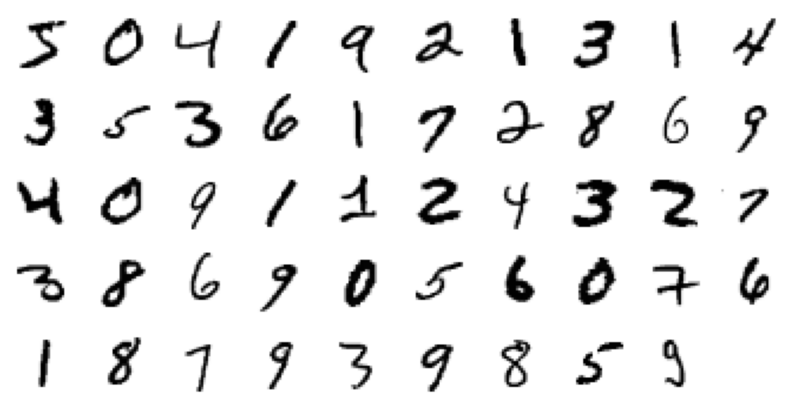

In [9]:
plot_mnist_image(x_train_full[:49])

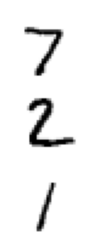

In [10]:
plot_mnist_image(x_test[:3], ncols=1)

## 데이터 셋 reshape & scaling

*   이미지 분류 합성곱 신경망에서는 이미지 배열의 모양이 (n_samples, height, width, n_channel)인 3차원 배열이라고 가정.
*   0. ~ 1. 실수 범위인 경우가 성능이 좋음.

In [11]:
np.max(x_train_full[0]), np.min(x_train_full[0])
#> 첫번째 이미지 픽셀의 최댓값, 최솟값 -> 0 ~ 255 사이의 부호 없는 8비트 정수.

(np.uint8(255), np.uint8(0))

In [12]:
x_train_full_scaled = x_train_full.reshape((-1, 28, 28, 1)) / 255.
x_test_scaled = x_test.reshape((-1, 28, 28, 1)) / 255.

In [13]:
x_train_full_scaled.shape

(60000, 28, 28, 1)

In [14]:
np.max(x_train_full_scaled), np.min(x_train_full_scaled)

(np.float64(1.0), np.float64(0.0))

## 훈련/검증 셋 분리

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full_scaled, y_train_full,
                                                  test_size=0.1,
                                                  stratify=y_train_full,
                                                  random_state=42)

In [16]:
x_train.shape

(54000, 28, 28, 1)

# 합성곱 신경망 생성

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential(layers=[
    keras.Input(shape=(28, 28, 1)),  # 입력층
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal'),  # 첫번째 합성곱
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal'),  # 두번째 합성곱
    keras.layers.MaxPool2D(),  # Max Pooling
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),  # 밀집층
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=10, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)